# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Analysis

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import zipfile 
import matplotlib.patches as mpatches
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.9.0



In [3]:
ls data/

stormwater-data.zip


In [4]:
gdf = gpd.read_file('data/stormwater-data.zip')

print(gdf.shape)
print(gdf.crs)
gdf.head()

(164033, 5)
epsg:2263


,Flooding_Category,Shape_Length,Shape_Area,flood_classification,geometry
0,1,11.396709,1.521997,Nuisance Flooding,"POLYGON Z ((917251.502 120925.181 0.000, 91725..."
1,1,38.406428,82.627967,Nuisance Flooding,"POLYGON Z ((917309.366 120944.469 0.000, 91729..."
2,1,24.389695,14.028213,Nuisance Flooding,"POLYGON Z ((917311.973 120963.757 0.000, 91730..."
3,1,198.696536,820.105280,Nuisance Flooding,"POLYGON Z ((917248.402 120964.877 0.000, 91725..."
4,1,50.837975,152.514946,Nuisance Flooding,"POLYGON Z ((917168.151 120963.757 0.000, 91715..."


In [5]:
(gdf
 .groupby(by='flood_classification')[['flood_classification']]
 .count()
 .rename(columns={'flood_classification':'count_polygons'})
)

,count_polygons
flood_classification,
Deep and Contiguous Flooding,53057
Future High Tides 2080,7121
Nuisance Flooding,103855


In [6]:
acres_conversion = 43560

(gdf
 .groupby(by='flood_classification')[['Shape_Area']]
 .sum()
 .div(acres_conversion)
 .round(0)
 .rename(columns={'Shape_Area':'shape_area_acres'})
)

,shape_area_acres
flood_classification,
Deep and Contiguous Flooding,8430.0
Future High Tides 2080,7934.0
Nuisance Flooding,9936.0


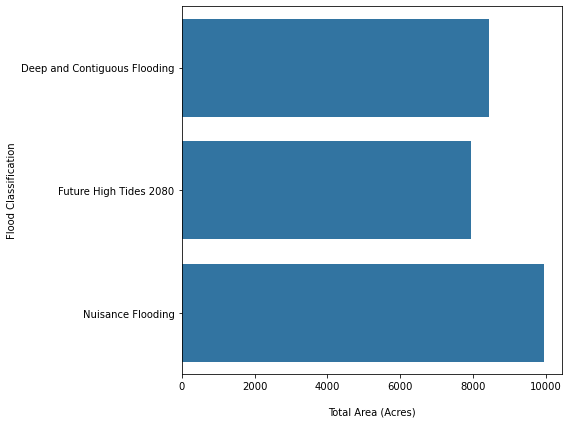

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

acres_conversion = 43560

bar = (
    gdf
    .groupby(by='flood_classification')[['Shape_Area']]
    .sum()
    .div(acres_conversion)
    .round(0)
    .rename(columns={'Shape_Area':'shape_area_acres'})
)

sns.barplot(
    data=bar,
    x='shape_area_acres',
    y=bar.index,
    color='C0',
    ax=ax
)

plt.xlabel('\nTotal Area (Acres)')
plt.ylabel('Flood Classification')
plt.tight_layout()

In [8]:
# importing borough boundaries for better aesthetics
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)

print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,4.0,Queens,3.041419e+09,888199.730955,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
3,1.0,Manhattan,6.365205e+08,357713.308660,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,3.0,Brooklyn,1.934138e+09,728148.532410,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."


In [9]:
borough_gdf.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [10]:
borough_gdf = borough_gdf.to_crs(2263)

borough_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'NYC Boroughs')

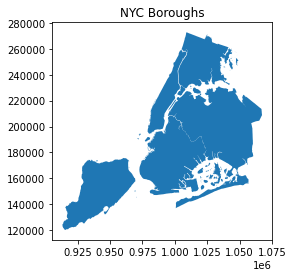

In [11]:
# quick plot of boroughs
borough_gdf.plot()
plt.title('NYC Boroughs')

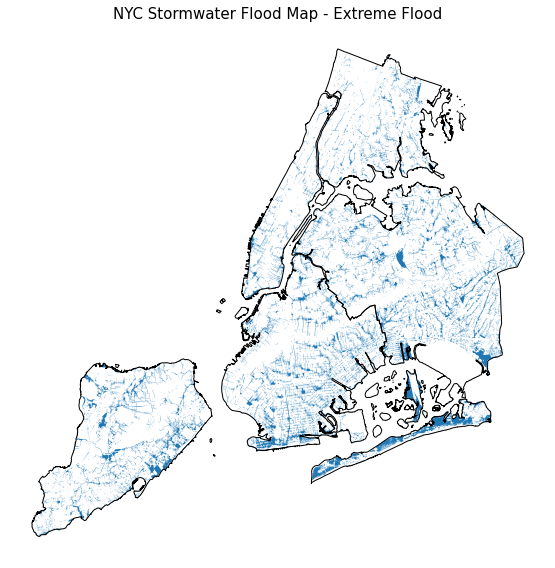

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(ax=ax)

borough_gdf.plot(
    ax=ax,
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.title('NYC Stormwater Flood Map - Extreme Flood', fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/stormwater-map.png', dpi=200)

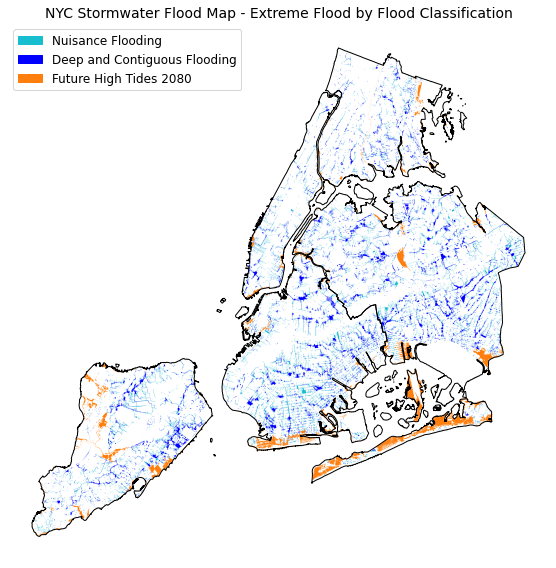

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

patches = []
colors = ['tab:cyan', 'blue', 'tab:orange']

for val, color in zip(gdf['flood_classification'].unique(), colors):
    (gdf
     .loc[gdf['flood_classification'].isin([val])]
     .plot(color=color, ax=ax))
    
    patches.append(mpatches.Patch(color=color, label=val))
    
borough_gdf.plot(
    ax=ax, 
    facecolor='none', 
    edgecolor='black', 
    zorder=1)

plt.legend(
    title='', 
    handles=patches, 
    fontsize='12', 
    title_fontsize='12',
    loc=2
) 

plt.axis('off')

title = 'NYC Stormwater Flood Map - Extreme Flood by Flood Classification'
plt.title(title, fontsize=14)
plt.tight_layout()
plt.savefig('figures/stormwater-class-map.png', bbox_inches='tight', dpi=200)

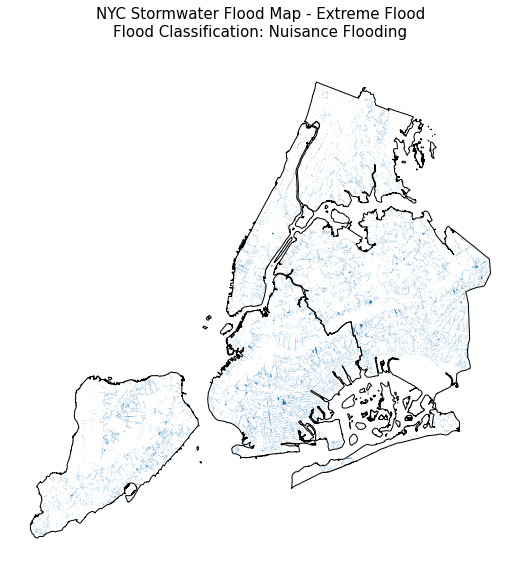

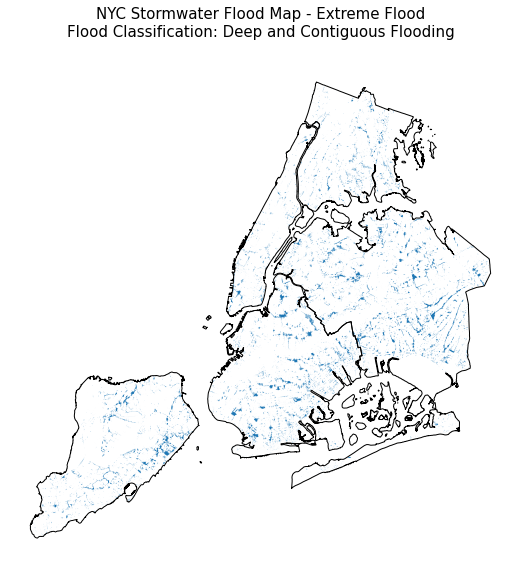

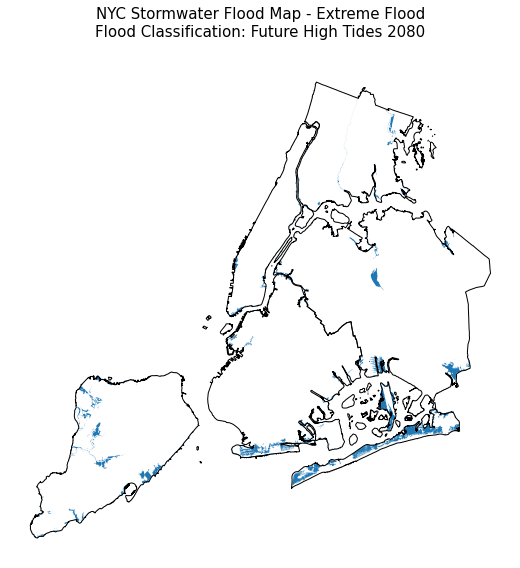

In [14]:
flood_classes = gdf['flood_classification'].unique()

for flood_class in flood_classes:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    (gdf
     .loc[gdf['flood_classification'].isin([flood_class])]
     .plot(color='C0', ax=ax))
    
    borough_gdf.plot(
        ax=ax,
        facecolor='none',
        edgecolor='black',
        zorder=1
    )
    
    title = 'NYC Stormwater Flood Map - Extreme Flood\nFlood Classification: {}\n'.format(flood_class)
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.tight_layout()

In [15]:
# flood_classes = gdf['flood_classification'].unique()
# colors = ['tab:cyan', 'blue', 'tab:orange']
# boros = borough_gdf['boro_name'].to_list()

# for boro in boros: 
#     fig, ax = plt.subplots(figsize=(8, 8))
#     patches = []
    
#     for flood_class, color in zip(flood_classes, colors):
#         (gdf
#          .loc[gdf['flood_classification'].isin([flood_class])]
#          .plot(color=color, ax=ax))
        
#         patches.append(mpatches.Patch(color=color, label=flood_class)) 

#     (borough_gdf
#      .loc[borough_gdf['boro_name'] == boro]
#      .plot(
#         ax=ax,
#         facecolor='none',
#         edgecolor='black',
#         linewidth=5,
#         zorder=1)
#     )

#     bounds = bounds_gdf.total_bounds
#     xmin, xmax = bounds[0], bounds[2]
#     ymin, ymax = bounds[1], bounds[3]
#     plt.xlim([xmin, xmax])
#     plt.ylim([ymin, ymax])
    
#     if boro == 'Manhattan':
#         loc = 2
#     elif boro == 'Staten Island':
#         loc = 4
#     elif boro == 'Queens':
#         loc = 4
#     else:
#         loc = 'best'
        
#     plt.legend(
#         title='', 
#         handles=patches, 
#         fontsize='13', 
#         title_fontsize='15', 
#         loc=loc
#     )
    
#     boro_lowercase = boro.lower().replace(" ", "-")
#     print(boro_lowercase, 'is done.')
    
#     plt.axis('off')
#     plt.title('{}, NYC Stormwater Flood Map - Extreme Flood\n'.format(boro), fontsize=15)    
#     plt.tight_layout()
#     plt.savefig('figures/{}-stormwater-map.png'.format(boro_lowercase), dpi=200)

In [16]:
boros = borough_gdf['boro_name'].unique()
lst = []

for boro in boros:
    print(boro + ':')
    mask = borough_gdf.loc[borough_gdf['boro_name'] == boro]
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    clipped = gpd.clip(gdf, mask)
    clipped['boro_clip'] = boro

    lst.append(clipped)
    print('clipping is done!\n')

clipped_gdf = pd.concat(lst)
clipped_gdf = clipped_gdf.reset_index(drop=True)

print(clipped_gdf.shape)
clipped_gdf.head()

Staten Island:
clipping is done!

Bronx:
clipping is done!

Queens:
clipping is done!

Manhattan:
clipping is done!

Brooklyn:
clipping is done!

(163823, 6)


,Flooding_Category,Shape_Length,Shape_Area,flood_classification,geometry,boro_clip
0,1,11.396709,1.521997,Nuisance Flooding,"POLYGON Z ((917251.502 120919.770 0.000, 91725...",Staten Island
1,1,38.406428,82.627967,Nuisance Flooding,"POLYGON Z ((917296.507 120944.469 0.000, 91729...",Staten Island
2,1,24.389695,14.028213,Nuisance Flooding,"POLYGON Z ((917309.366 120952.982 0.000, 91730...",Staten Island
3,1,198.696536,820.105280,Nuisance Flooding,"POLYGON Z ((917259.655 120957.367 0.000, 91727...",Staten Island
4,1,50.837975,152.514946,Nuisance Flooding,"POLYGON Z ((917155.062 120963.757 0.000, 91715...",Staten Island


In [17]:
clipped_gdf['Shape_Area'] = clipped_gdf.area
clipped_gdf['Shape_Length'] = clipped_gdf.length

clipped_gdf.head()

,Flooding_Category,Shape_Length,Shape_Area,flood_classification,geometry,boro_clip
0,1,11.396709,1.521997,Nuisance Flooding,"POLYGON Z ((917251.502 120919.770 0.000, 91725...",Staten Island
1,1,38.406428,82.627967,Nuisance Flooding,"POLYGON Z ((917296.507 120944.469 0.000, 91729...",Staten Island
2,1,24.389695,14.028213,Nuisance Flooding,"POLYGON Z ((917309.366 120952.982 0.000, 91730...",Staten Island
3,1,198.696536,820.105280,Nuisance Flooding,"POLYGON Z ((917259.655 120957.367 0.000, 91727...",Staten Island
4,1,50.837975,152.514946,Nuisance Flooding,"POLYGON Z ((917155.062 120963.757 0.000, 91715...",Staten Island


staten-island is done.
bronx is done.
queens is done.
manhattan is done.
brooklyn is done.


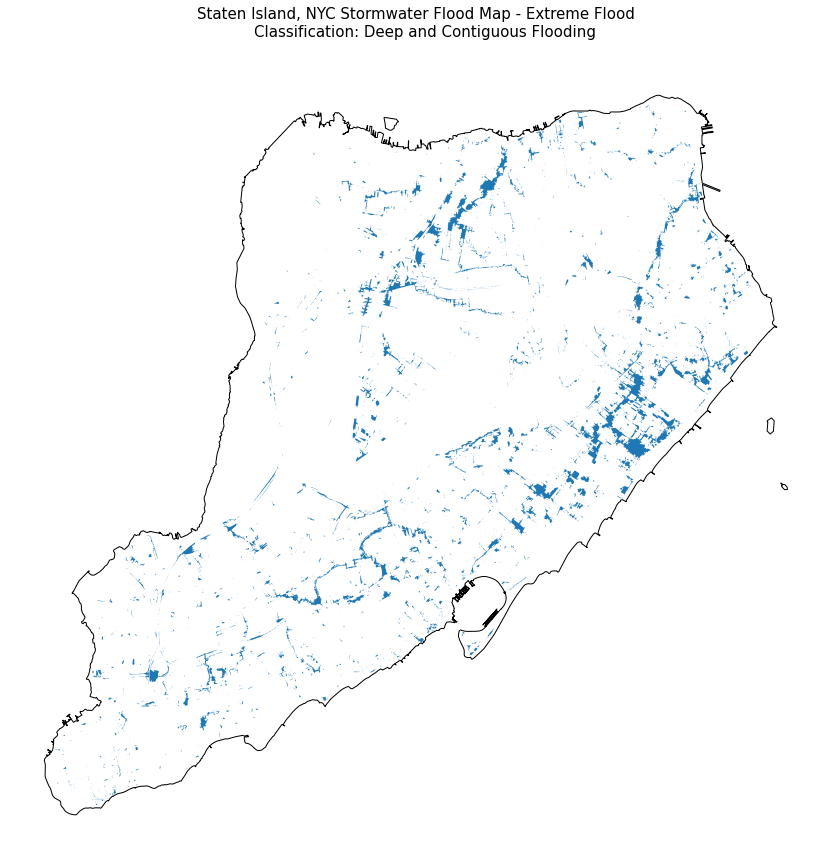

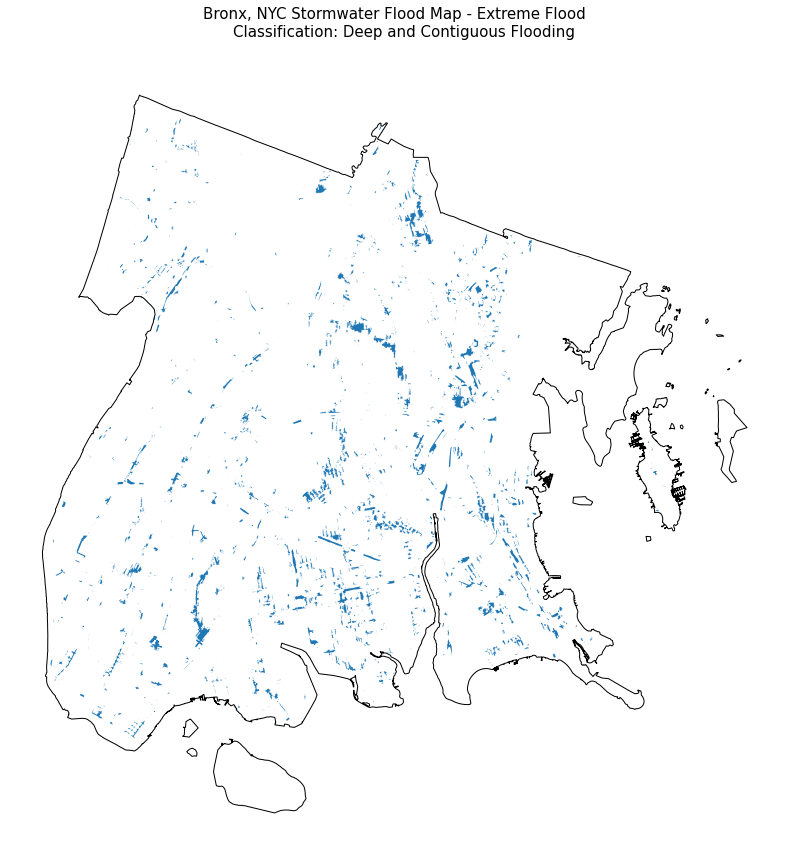

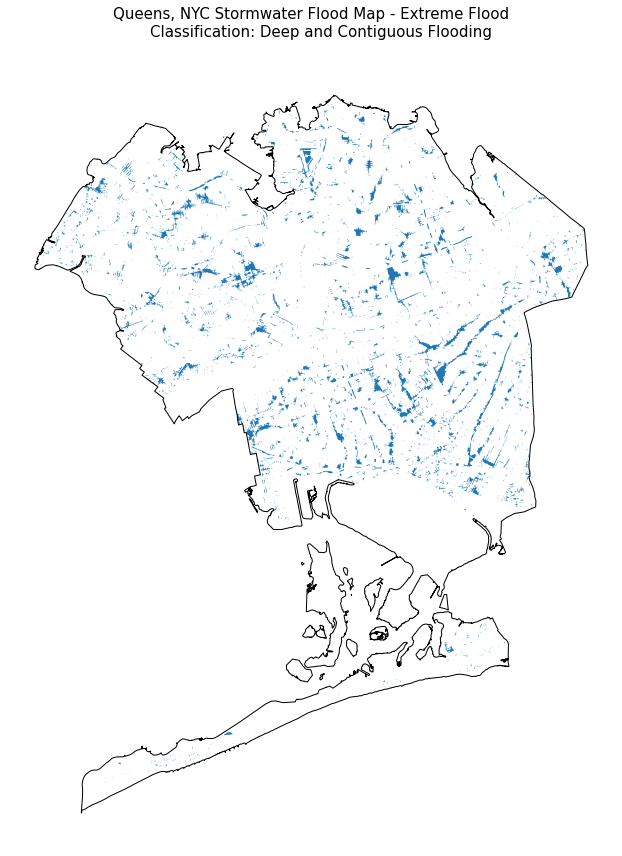

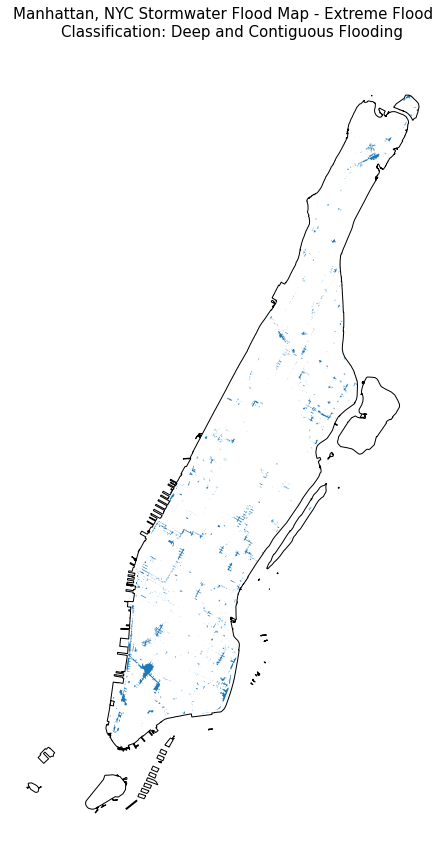

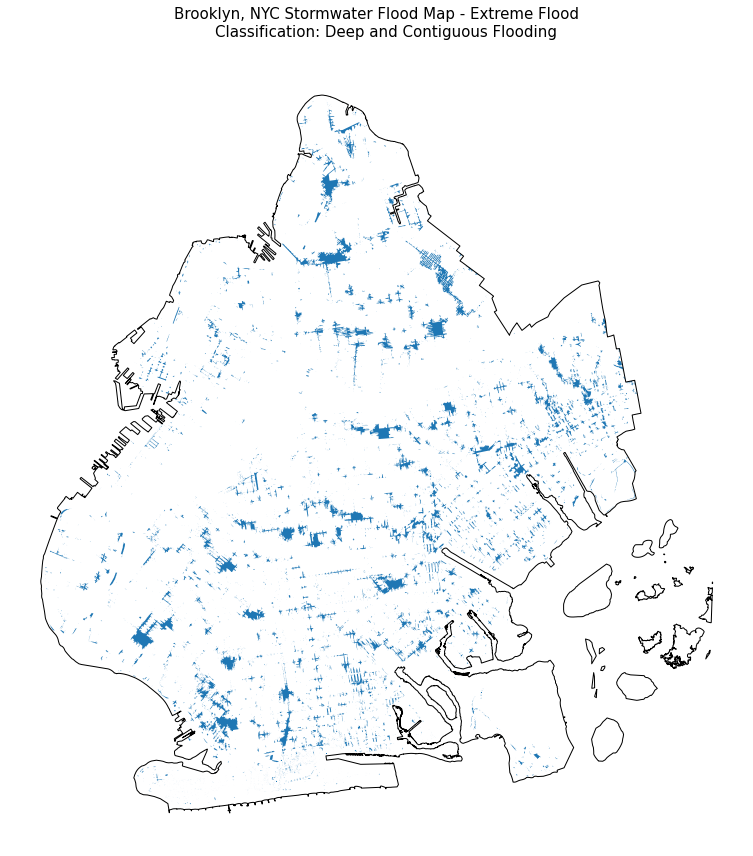

In [18]:
boros = borough_gdf['boro_name'].to_list()
deep_df = clipped_gdf.loc[clipped_gdf['flood_classification'] == 'Deep and Contiguous Flooding']

for boro in boros: 
    fig, ax = plt.subplots(figsize=(12, 12))
    
    plot = deep_df.loc[deep_df['boro_clip'].isin([boro])]
    plot.plot(ax=ax)

    bounds_gdf = borough_gdf.loc[borough_gdf['boro_name'] == boro] 
    bounds_gdf.plot(ax=ax, facecolor='none', edgecolor='black', zorder=1)
    
    boro_lowercase = boro.lower()
    boro_lowercase = boro_lowercase.replace(" ", "-")
    print(boro_lowercase, 'is done.')

    plt.axis('off')
    plt.title('{}, NYC Stormwater Flood Map - Extreme Flood\n\
    Classification: Deep and Contiguous Flooding\n'.format(boro), fontsize=15)   
    plt.tight_layout()
    plt.savefig('figures/{}-deep-flood-stormwater-map.png'.format(boro_lowercase), dpi=200)

In [19]:
boro_area = (
    deep_df
    .groupby(by='boro_clip')[['Shape_Area']]
    .sum()
) 

boro_area = (
    boro_area
    .merge(
        borough_gdf.loc[:, ['boro_name', 'shape_area']],
        left_on='boro_clip',
        right_on='boro_name')
    .rename(columns={'shape_area':'boro_area',
                     'boro_clip':'borough'})
)

boro_area.head()

,Shape_Area,boro_name,boro_area
0,3.282382e+07,Bronx,1.187175e+09
1,1.026450e+08,Brooklyn,1.934138e+09
2,1.636082e+07,Manhattan,6.365205e+08
3,1.480504e+08,Queens,3.041419e+09
4,6.728373e+07,Staten Island,1.623621e+09


In [20]:
boro_area['area_normalized'] = boro_area['Shape_Area'] / boro_area['boro_area']

boro_area.head()

,Shape_Area,boro_name,boro_area,area_normalized
0,3.282382e+07,Bronx,1.187175e+09,0.027649
1,1.026450e+08,Brooklyn,1.934138e+09,0.053070
2,1.636082e+07,Manhattan,6.365205e+08,0.025704
3,1.480504e+08,Queens,3.041419e+09,0.048678
4,6.728373e+07,Staten Island,1.623621e+09,0.041441


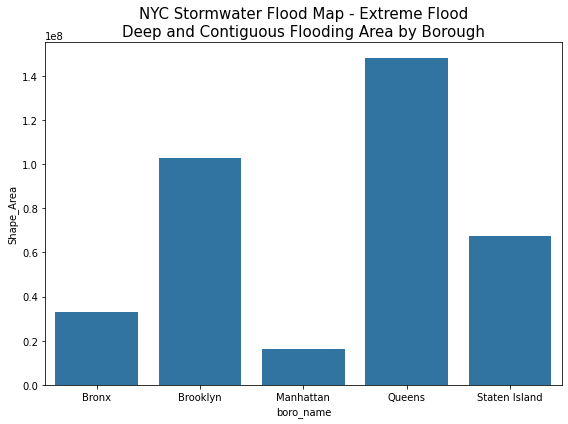

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=boro_area, 
            x='boro_name', 
            y='Shape_Area', 
            color='C0',
            ax=ax)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Deep and Contiguous Flooding Area by Borough', fontsize=15)
plt.tight_layout()

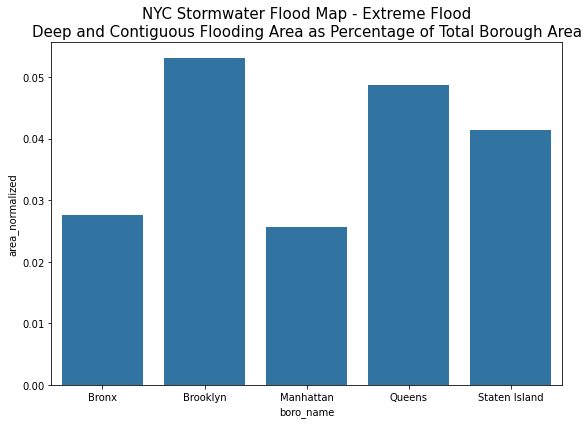

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=boro_area, 
            x='boro_name', 
            y='area_normalized', 
            color='C0',
            ax=ax)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Deep and Contiguous Flooding Area as Percentage of Total Borough Area', fontsize=15)
plt.tight_layout()
plt.savefig('figures/deep-flooding-stormwater-bar.png', dpi=200)

staten-island is done!
bronx is done!
queens is done!
manhattan is done!
brooklyn is done!


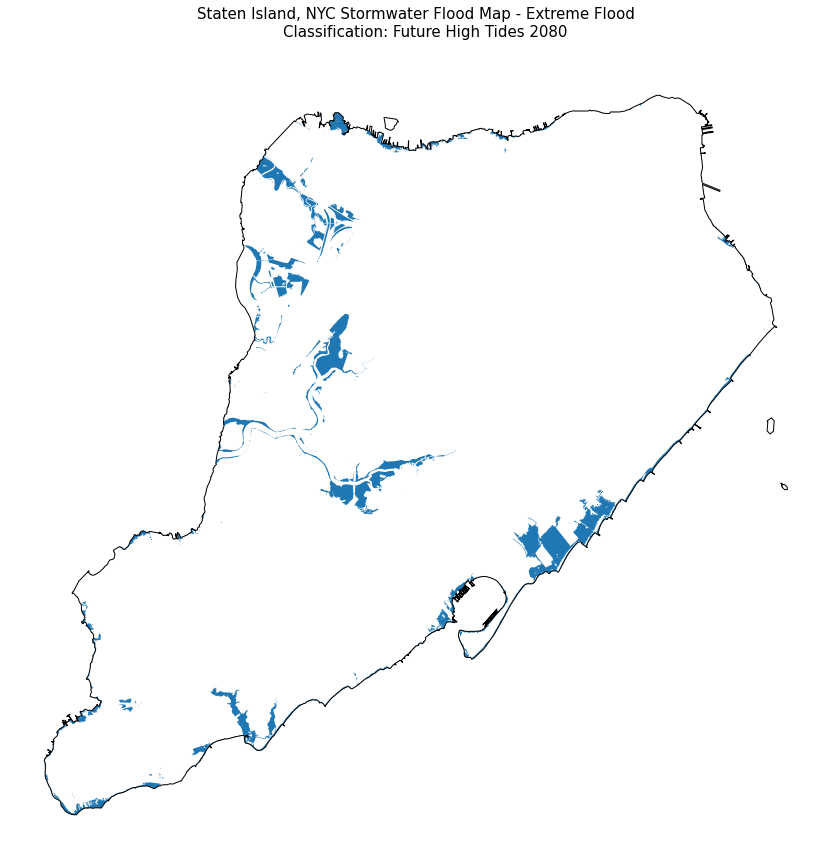

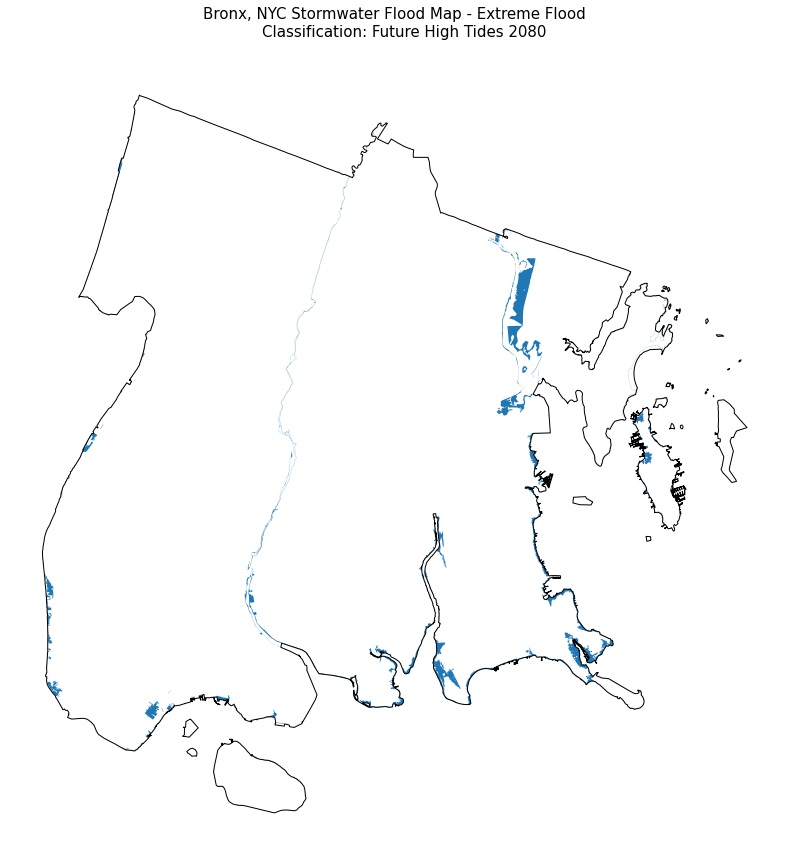

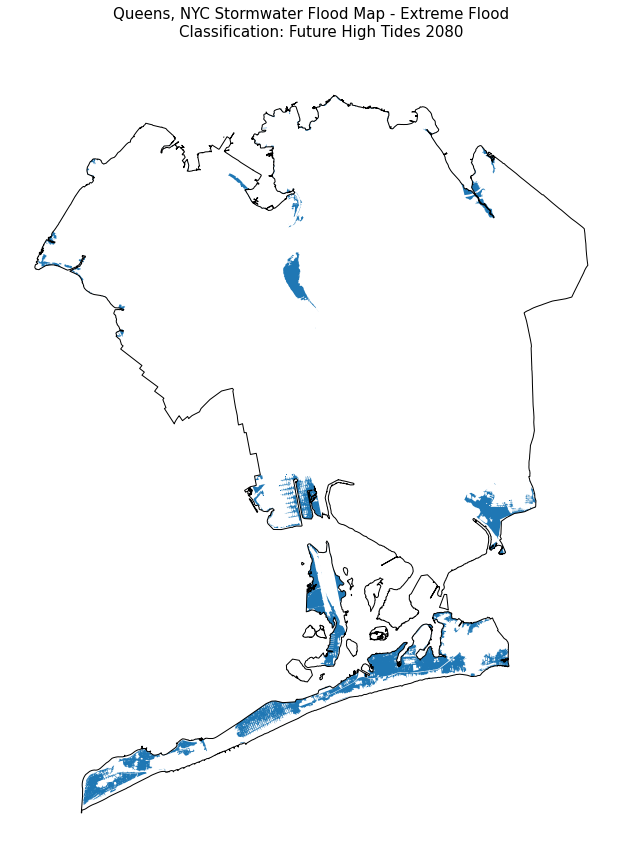

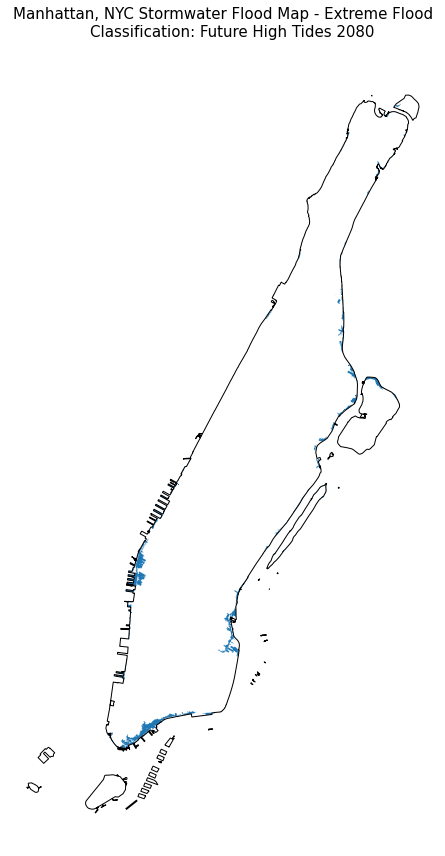

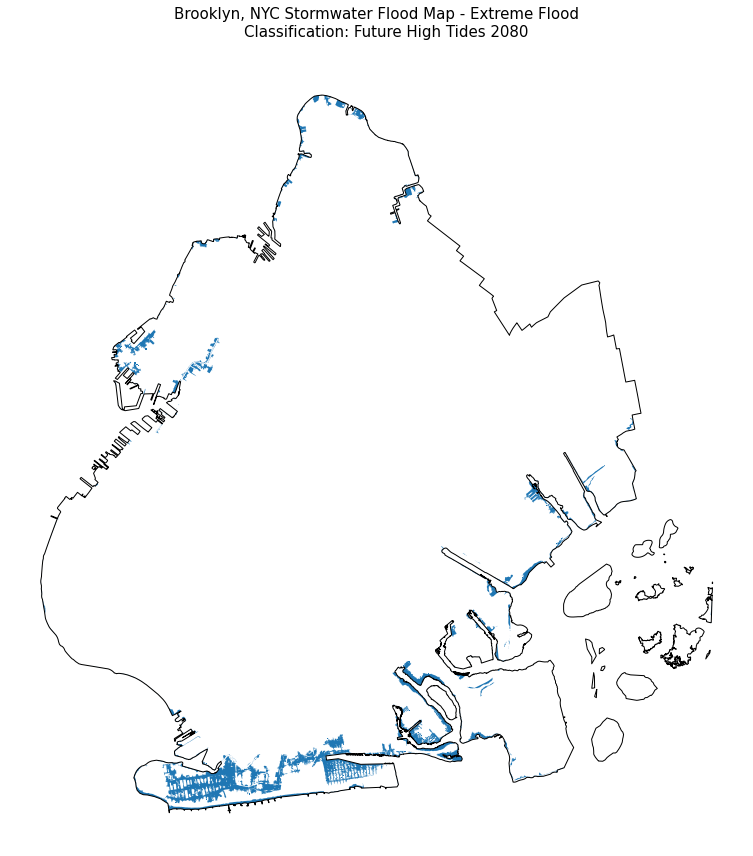

In [23]:
boros = borough_gdf['boro_name'].to_list()
high_tides_df = clipped_gdf.loc[clipped_gdf['flood_classification'] == 'Future High Tides 2080']

for boro in boros: 
    fig, ax = plt.subplots(figsize=(12, 12))
    
    high_tides_df.loc[high_tides_df['boro_clip'].isin([boro])].plot(ax=ax)

    bounds_gdf = borough_gdf.loc[borough_gdf['boro_name'] == boro] 
    bounds_gdf.plot(ax=ax, facecolor='none', edgecolor='black', zorder=1)
    
    boro_lowercase = boro.lower()
    boro_lowercase = boro_lowercase.replace(" ", "-")
    print(boro_lowercase, 'is done!')

    plt.axis('off')
    plt.title('{}, NYC Stormwater Flood Map - Extreme Flood\n\
    Classification: Future High Tides 2080\n'.format(boro), fontsize=15)   
    plt.tight_layout()
    plt.savefig('figures/{}-high-tides-stormwater-map.png'.format(boro_lowercase), dpi=200)

In [24]:
boro_area = high_tides_df.groupby(by='boro_clip')['Shape_Area'].sum().reset_index()
boro_area = boro_area.merge(borough_gdf[['boro_name', 'shape_area']], 
                            left_on='boro_clip', 
                            right_on='boro_name').drop(columns=['boro_name'])
boro_area = boro_area.rename(columns={'shape_area':'boro_area', 
                                      'boro_clip':'borough'})

boro_area.head()

,borough,Shape_Area,boro_area
0,Bronx,2.059237e+07,1.187175e+09
1,Brooklyn,5.509592e+07,1.934138e+09
2,Manhattan,1.537913e+07,6.365205e+08
3,Queens,1.649414e+08,3.041419e+09
4,Staten Island,6.368227e+07,1.623621e+09


In [25]:
boro_area['area_normalized'] = boro_area['Shape_Area'] / boro_area['boro_area']

boro_area.head()

,borough,Shape_Area,boro_area,area_normalized
0,Bronx,2.059237e+07,1.187175e+09,0.017346
1,Brooklyn,5.509592e+07,1.934138e+09,0.028486
2,Manhattan,1.537913e+07,6.365205e+08,0.024161
3,Queens,1.649414e+08,3.041419e+09,0.054232
4,Staten Island,6.368227e+07,1.623621e+09,0.039222


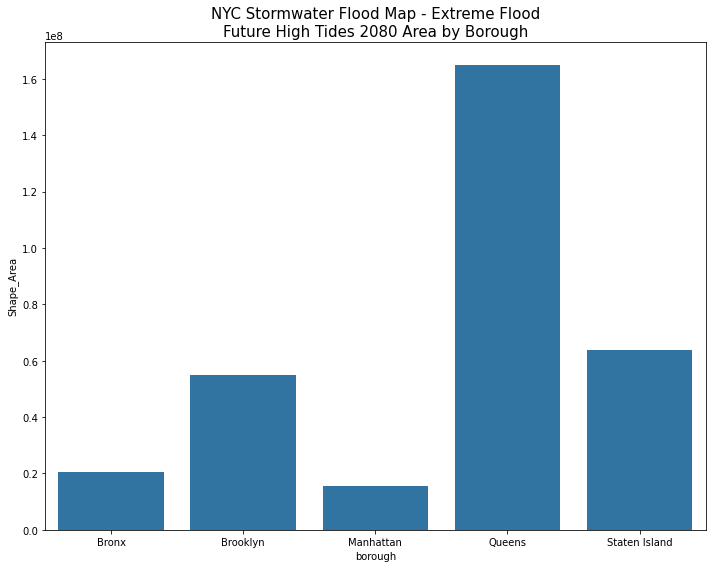

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=boro_area, 
            x='borough', 
            y='Shape_Area', 
            color='C0',
            ax=ax)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Future High Tides 2080 Area by Borough', fontsize=15)
plt.tight_layout()

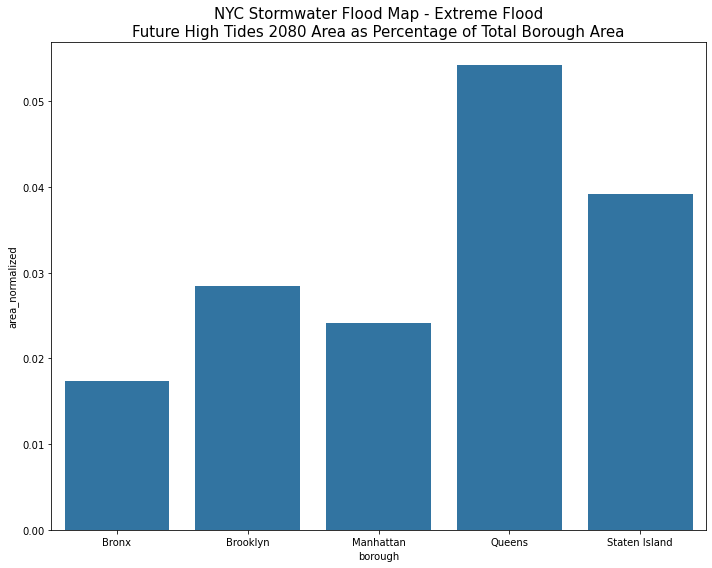

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=boro_area, 
            x='borough', 
            y='area_normalized', 
            color='C0',
            ax=ax)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Future High Tides 2080 Area as Percentage of Total Borough Area', fontsize=15)
plt.tight_layout()
plt.savefig('figures/high-tides-stormwater-bar.png', dpi=200)